# 特征选择：丢掉坏属性

**特征选择**是从原始数据中**选择**对于预测流水线而言**最好**的特征的过程。更正式地说，给定n个特征，我们搜索其中包含K（k＜n）个特征的子集来改善机器学习流水线的性能。一般而言：**特征选择**尝试**剔除**数据中的**噪声**。

这个定义包括两个需要解决的问题：

- 如何找到k特征子集？
- 在机器学习中，什么叫“更好”？

特征选择的方法分为两大类：

- 基于统计的特征选择
- 基于模型的特征选择

这种分类也许不能100%捕捉到特征选择在科学性和艺术性上的复杂程度，但是可以推动机器学习流水线输出真实、有效的结果。

本章内容：

- 在特征工程中实现更好的性能
- 创建基准机器学习流水线
- 特征选择的类型
- 选用正确的特征选择方法

## 5.1 在特征工程中实现更好的性能

当讨论特征工程的方法时，需要对“更好”下定义。实际上，我们的目标是实现**更好的预测性能**，而且仅使用简单的指标进行测量，例如分类任务的**准确率**和回归任务的**均方根误差**。除此之外，还可以测量和跟踪其他指标，以评估预测的性能。例如，分类任务可以使用如下指标：

- 真阳性率和假阳性率
- 灵敏度（真阳性率）和特异性
- 假阴性率和假阳性率。

回归任务则可以使用：
- 平均绝对误差
- R方

还有不直接于模型预测性能相关的**元指标**：

- 模型拟合/训练所需的时间
- 拟合后的模型预测新实例的时间
- 需要持久化（永久保存）的数据大小

为了跟踪这些指标，可以创建一个函数，通用到足以评估若干模型，同时精细到可以提供每个模型的指标，以完成一些任务：

- 搜索所有给定的参数，优化机器学习流水线
- 输出有助于评估流水线质量的指标

该函数的定义如下：

In [1]:
# 导入网格搜索模块
from sklearn.model_selection import GridSearchCV

def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, # 要搜索的模型
                        params, # 要尝试的参数
                        error_score=0.) # 如果报错，结果是0
    
    grid.fit(X, y) # 拟合模型和参数
    # 经典的性能指标
    print("最高准确率: {}".format(grid.best_score_))
    # 得到最佳准确率的最佳参数
    print("最佳参数: {}".format(grid.best_params_))
    # 拟合的平均时间（秒）
    print("拟合的平均时间(s):{}"
          .format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    # 预测的平均时间（秒）
    # 从该指标可以看出模型在真实世界的性能
    print("预测的平均时间(s):{}"
          .format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

这个函数的总体目标是给出一个基线数据，以便于评估每个特征选择方法，同时也更加标准化。

### 案例分析：信用卡逾期数据集

**特征选择算法**可以智能地从数据中提取最重要的信号并忽略噪声，达到以下两个结果：

- **提升模型性能**：在删除冗余数据后，基于噪声和不相关数据做出错误决策的情况会减少，而且模型可以在重要的特征上练习，提高预测性能。
- **减少训练和预测时间**：因为拟合的数据更少，所以模型一般在拟合和训练上有速度提升，让流水线的整体速度更快

为了更好地理解噪声以及为什么噪声有副作用，这里介绍一个新的数据集：**[信用卡逾期数据集](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)**。此数据集包含23个特征和一个响应变量。这个变量是一个布尔值，可以是True（真）或False（假）。

我们的任务是：在23个特征中找出对机器学习流水线**有益**和**有害**的特征。

首先，导入数据集：

In [34]:
import pandas as pd
import numpy as np
# 用随机数种子保证随机数一致
np.random.seed(123)
credit_card = pd.read_csv('sample_data/credit_card_default.csv')
credit_card.drop('ID', axis=1, inplace=True)
credit_card.shape

(30000, 24)

先进行基本的探索性数据分析。检查一下数据集的大小和描述性统计：

In [35]:
credit_card.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


其中，dpnm(default payment next month，下个月逾期）是响应，其他都是特征。很明显，特征的尺度迥异，这是选择数据处理方法和模型时需要考虑的问题。可以使用StandardScalar和归一化解决了这些问题，这里暂时忽略这些问题，以便集中处理更相关的问题。

先快速检查一下，确保不存在缺失值问题：

In [36]:
credit_card.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dpnm         0
dtype: int64

太好了，没有缺失值。接下来为机器学习流水线设置变量：

In [37]:
# 特征矩阵
X = credit_card.drop(['dpnm'], axis=1)
# 响应变量
y = credit_card['dpnm']
X.shape

(30000, 23)

In [38]:
# 空准确率
y.value_counts(normalize=True)

0    0.7788
1    0.2212
Name: dpnm, dtype: float64

本例需要击败77.88%这个准确率，也就是没有逾期者的比例（0代表没有逾期）。

## 5.2 创建基准机器学习流水线

本章的目标是寻找最符合我们需求的机器学习模型，然后通过特征选择来增强模型。先导入4种模型： 

- 逻辑回归
- K最近邻（KNN）
- 决策树
- 随机森林

然后后执行get_best_model_and_accuracy函数，取得每个模型处理原始数据的基准。代码如下：

In [39]:
# 导入4 种模型
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# 忽略警告
import warnings
warnings.filterwarnings("ignore")

# 为网格搜索设置变量
# 先设置机器学习模型的参数

# 逻辑回归
lr_params = {
    'C': [1e-1, 1e0, 1e1, 1e2],
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2']
}

# KNN
knn_params = {
    'n_neighbors': [1, 3, 5, 7]
}

# 决策树
dt_params = {
    'max_depth':[None, 1, 3, 5, 7]
}

# 随机森林
rf_params = {
    'n_estimators': [10, 50, 100], 
    'max_depth': [None, 1, 3, 5, 7]
}

# 实例花机器学习模型
lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

# 在所以模型上运行评估函数，了解各个模型的好坏：
print('*' * 20, '逻辑回归', '*' * 20)
get_best_model_and_accuracy(lr, lr_params, X, y)
print('*' * 20, 'K最近邻', '*' * 20)
get_best_model_and_accuracy(knn, knn_params, X, y)

******************** 逻辑回归 ********************
最高准确率: 0.8099333333333334
最佳参数: {'C': 100.0, 'penalty': 'l1', 'solver': 'liblinear'}
拟合的平均时间(s):0.828
预测的平均时间(s):0.003
******************** K最近邻 ********************
最高准确率: 0.7617333333333333
最佳参数: {'n_neighbors': 7}
拟合的平均时间(s):0.099
预测的平均时间(s):0.993


可见，逻辑回归只用原始数据就打败了空准确率(77.88%)，KNN在拟合时间上表现得更好，但其准确率甚至不如空准确率，原因是：KNN是按照欧几里得距离进行预测的，在非标准数据上可能会失效，但是其他3个算法不会受此影响。因此对于KNN，需要更复杂的流水线，以更准确地评估基准性能：

In [49]:
# 导入所需的包
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# 为流水线设置KNN参数
knn_pipe_params = {'classifier__{}'
                   .format(k): v for k, v in knn_params.items()}
# KNN需要标准化的参数
knn_pipe = Pipeline([('scale', StandardScaler()), ('classifier', knn)])
# 拟合快，预测慢
print('*' * 20, 'K最近邻(标准化)', '*' * 20)
get_best_model_and_accuracy(knn_pipe, knn_pipe_params, X, y)

******************** K最近邻(标准化) ********************
最高准确率: 0.7993333333333333
最佳参数: {'classifier__n_neighbors': 7}
拟合的平均时间(s):0.111
预测的平均时间(s):7.428


在用StandardScalar进行z分数标准化处理后，这个流水线的准确率（79.93%）至少比空准确率（77.88%）要高，但是这也严重影响了预测时间，因为多了一个预处理步骤。目前，逻辑回归依然领先：准确率（80.99%）更高，速度更快。

下面继续讨论两个基于树的模型，从更简单的决策树开始：

In [50]:
print('*' * 20, '决策树', '*' * 20)
get_best_model_and_accuracy(dt, dt_params, X, y)

******************** 决策树 ********************
最高准确率: 0.8206333333333333
最佳参数: {'max_depth': 3}
拟合的平均时间(s):0.244
预测的平均时间(s):0.003


现在决策树的准确率（82.06%）是第一，而且拟合和预测的速度也很快。实际上，决策树的拟合速度比逻辑回归快，预测速度比KNN快。最后测试一下随机森林：

In [51]:
print('*' * 20, '随机森林', '*' * 20)
get_best_model_and_accuracy(rf, rf_params, X, y)

******************** 随机森林 ********************
最高准确率: 0.8208000000000002
最佳参数: {'max_depth': 7, 'n_estimators': 100}
拟合的平均时间(s):1.732
预测的平均时间(s):0.045


随机森林的准确率（82.08%）比逻辑回归和KNN都好，比决策树稍好。汇总一下结果，看看应该使用哪个模型：

| 模  型 | 准确率（%） | 拟合时间（s） | 预测时间（s） |
| :--  | :--: | :--: | :--: |
| 逻辑回归  | 80.99% | 0.828 | 0.003 |
| KNN（标准化） | 79.93% | 0.111 | 7.428 |
| 决策树 | 82.06% | 0.224 | 0.003 |
| 随机森林 | 82.08% | 1.732 | 0.045 |

决策树的准确率略低于随机森林，但预测时间和逻辑回归并列第一，而带缩放的KNN拟合最快.总体而言，决策树应该是最适合下一步采用的模型，因为它在两个最重要的指标上领先：

- 最高的准确率，保证预测的准确性
- 考虑到实时生产环境，预测时间低大有裨益

既然要使用决策树，那么：

- 要击败的新基线准确率是82.06%，即拟合整个数据集的准确率
- 不再需要StandardScaler了，因为决策树不受其影响

## 5.3 特征选择的类型

选择特征是为了提高预测能力，降低时间成本。因此这里介绍两种类型：

- 基于统计的特征选择：依赖于机器学习模型之外的统计测试，以便在流水线的训练阶段选择特征
- 基于模型的特征选择：依赖于一个预处理步骤，需要训练一个辅助的机器学习模型，并利用其预测能力来选择特征

这两种类型都试图从原始特征中选择一个子集，减少数据大小，只留下预测能力最高的特征。

首先，我们研究如何依靠**统计测试**从数据集中选择可行的特征。

### 基于统计的特征选择

通过统计数据，可以快速、简便地解释定量和定性数据。均值和标准差是计算z分数和数据缩放的指标。本章会使用两个新概念帮我们选择特征：

- 皮尔逊相关系数（Pearson correlations）
- 假设检验

#### 1.使用皮尔逊相关系数

先看一下相关系统：

In [40]:
credit_card.corr()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
LIMIT_BAL,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_1,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
PAY_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149


皮尔逊相关系数（是Pandas默认的）会测量列之间的线性关系。该系数在-1～1变化，0代表没有线性关系。相关性接近-1或1代表线性关系很强。

Pandas的corr()方法会为所有的列计算皮尔逊相关系数。这个24×24的矩阵很难读，我们用热图优化一下：

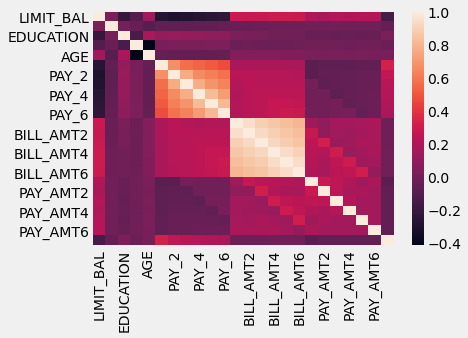

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('fivethirtyeight')
sns.heatmap(credit_card.corr())

plt.show()

只看一下特征和响应的相关性：

In [43]:
credit_card.corr()['dpnm']

LIMIT_BAL   -0.153520
SEX         -0.039961
EDUCATION    0.028006
MARRIAGE    -0.024339
AGE          0.013890
PAY_1        0.324794
PAY_2        0.263551
PAY_3        0.235253
PAY_4        0.216614
PAY_5        0.204149
PAY_6        0.186866
BILL_AMT1   -0.019644
BILL_AMT2   -0.014193
BILL_AMT3   -0.014076
BILL_AMT4   -0.010156
BILL_AMT5   -0.006760
BILL_AMT6   -0.005372
PAY_AMT1    -0.072929
PAY_AMT2    -0.058579
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT5    -0.055124
PAY_AMT6    -0.053183
dpnm         1.000000
Name: dpnm, dtype: float64

最后一行可以忽略，因为这是响应变量和自己的相关性。我们寻找相关系数接近-1或1的特征，因为这些特征应该会对预测有用。我们用Pandas过滤出相关系数超过正负0.2的特征:

In [44]:
credit_card.corr()['dpnm'].abs() > .2

LIMIT_BAL    False
SEX          False
EDUCATION    False
MARRIAGE     False
AGE          False
PAY_1         True
PAY_2         True
PAY_3         True
PAY_4         True
PAY_5         True
PAY_6        False
BILL_AMT1    False
BILL_AMT2    False
BILL_AMT3    False
BILL_AMT4    False
BILL_AMT5    False
BILL_AMT6    False
PAY_AMT1     False
PAY_AMT2     False
PAY_AMT3     False
PAY_AMT4     False
PAY_AMT5     False
PAY_AMT6     False
dpnm          True
Name: dpnm, dtype: bool

上面Pandas Series中的False代表特征的相关系数在-0.2～0.2之间，True则代表相关系数超过了正负0.2。下面过滤出相关度大于0.2的特征：

In [46]:
col_filter = credit_card.corr()['dpnm'].abs() > .2
highly_corr_features = credit_card.columns[col_filter]
highly_corr_features

Index(['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'dpnm'], dtype='object')

highly_corr_features变量会存储与响应变量高度相关的特征，但是需要删掉响应列，因为在机器学习流水线中包括这列等于作弊：

In [47]:
highly_corr_features = highly_corr_features.drop('dpnm')
highly_corr_features

Index(['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5'], dtype='object')

下面使用原始数据集中的这5个高相关度的特征，预测响应变量，看一下准确度：

In [48]:
X_subsetted = X[highly_corr_features]

get_best_model_and_accuracy(dt, dt_params, X_subsetted, y)

最高准确率: 0.8213333333333332
最佳参数: {'max_depth': 3}
拟合的平均时间(s):0.015
预测的平均时间(s):0.003


准确率比要击败的0.8206略高，并且拟合时间快了20倍。我们的模型只需要5个特征就可以学习整个数据集，而且速度快得多。

接下来使用scikit-learn流水线，将**相关性选择**作为预处理阶段的一部分。我们需要创建一个自定义转换器调用刚才的逻辑，并封装为流水线可以使用的类。

这个类命名为CustomCorrelationChooser，它会实现一个拟合逻辑和一个转换逻辑：

- 拟合逻辑：从特征矩阵中选择相关性高于阈值的列
- 转换逻辑：对数据集取子集，只包含重要的列

In [52]:
from sklearn.base import TransformerMixin, BaseEstimator

class CustomCorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        # 保存响应变量
        self.response = response
        # 保存阈值
        self.threshold = threshold
        # 初始化一个变量，存放要保留的特征名
        self.cols_to_keep = cols_to_keep

    def transform(self, X):
        # 转换会选择合适的列
        return X[self.cols_to_keep]

    def fit(self, X, *_):
        # 创建新的DataFrame，存放特征和响应
        df = pd.concat([X, self.response], axis=1)
        # 保存高于阈值的列的名称
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() >
    self.threshold]
        # 只保留X的列，删掉响应变量
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        return self

测试一下：

In [54]:
# 实例化特征选择器
ccc = CustomCorrelationChooser(threshold=.2, response=y)
ccc.fit(X)
ccc.cols_to_keep

['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

在X矩阵上应用转换:

In [55]:
ccc.transform(X).head()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5
0,2,2,-1,-1,-2
1,-1,2,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,-1,0,-1,0,0


可见，transform方法删除了其他列，只保留大于0.2阈值的列。现在在流水线中把一切组装起来：

In [56]:
from copy import deepcopy
# 使用响应变量初始化特征选择器
ccc = CustomCorrelationChooser(response=y)
# 创建流水线，包括选择器
ccc_pipe = Pipeline([
    ('correlation_select', ccc),
    ('classifier', dt)
])

tree_pipe_params = {
    'classifier__max_depth':[None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
}
# 复制决策树的参数
ccc_pipe_params = deepcopy(tree_pipe_params)
# 更新决策树的参数选择
ccc_pipe_params.update({
    'correlation_select__threshold':[0, .1, .2, .3]
})

get_best_model_and_accuracy(ccc_pipe, ccc_pipe_params, X, y)

最高准确率: 0.8207333333333333
最佳参数: {'classifier__max_depth': 3, 'correlation_select__threshold': 0.2}
拟合的平均时间(s):0.141
预测的平均时间(s):0.004


第一次的特征选择就已经打败了目标（虽然只高一点点）。我们的流水线显示，如果把阈值设为0.2，就足以消除噪声以提高准确性，并缩短拟合时间（0.141）。

#### 2.使用假设检验

**假设检验**是一种**统计学**方法，可以对单个特征进行复杂的**统计检验**。在特征选择中使用假设检验可以像之前的自定义相关选择器一样，尝试从数据集中选择**最佳特征**，但是这里的检验更依赖于形式化的统计方法，并通过所谓的p值进行检验。

作为一种统计检验，假设检验用于在给定数据样本时确定可否在整个数据集上应用某种条件。假设检验的结果会告诉我们是否应该相信或拒绝假设（并选择另一个假设）。

在特征选择中，假设测试的原则是：“**特征与响应变量没有关系**”（零假设）为真还是假。我们需要**在每个特征上进行检验，并决定其与响应变量是否有显著关系**。在某种程度上说，相关性检测逻辑也是这样运作的。如果某个特征与响应变量的相关性太弱，那么认为“特征与响应变量没有关系”这个假设为真。如果相关系数足够强，那么拒绝该假设，认为特征与响应变量有关。

在将其用于数据之前，需要导入新模块SelectKBest和f_classif，代码如下：

In [57]:
# SelectKBest选择K个最好的特征
from sklearn.feature_selection import SelectKBest
# ANOVA测试
from sklearn.feature_selection import f_classif

SelectKBest基本上就是包装了一定数量的特征，而这些特征是根据某个标准保留的前几名。这里使用假设检验的p值作为排名依据。

##### 理解p值

p值是**介于0和1**的小数，代表在假设检验下，给定**数据偶然出现的概率**。简而言之，p值越低，拒绝零假设的概率越大。在我们的例子中，p值越低，这个特征与响应变量有关联的概率就越大，就越应该保留这个特征。

需要注意的是，f_classif函数在每个特征上单独（单变量测试由此得名）执行一次ANOVA测试（一种假设检验类型），并分配一个p值。SelectKBest会将特征按p值排列（越小越好），只保留指定的k个最佳特征。

##### p值排列

首先实例化一个SelectKBest对象，并手动设定k是5，代表只希望保留5个最佳的特征：

In [58]:
k_best = SelectKBest(f_classif, k=5)

然后可以像之前使用自定义选择器那样，拟合并转化X矩阵，选择需要的特征：

In [59]:
# 选择最佳特征后的矩阵
k_best.fit_transform(X, y)

array([[ 2,  2, -1, -1, -2],
       [-1,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       ...,
       [ 4,  3,  2, -1,  0],
       [ 1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

如果想直接查看p值并检查选择了哪些特征，可以深入观察k_best变量：

In [60]:
# 查看所有列的p值
k_best.pvalues_

array([1.30224395e-157, 4.39524880e-012, 1.22503803e-006, 2.48536389e-005,
       1.61368459e-002, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       1.89929659e-315, 1.12660795e-279, 7.29674048e-234, 6.67329549e-004,
       1.39573624e-002, 1.47699827e-002, 7.85556416e-002, 2.41634443e-001,
       3.52122521e-001, 1.14648761e-036, 3.16665676e-024, 1.84177029e-022,
       6.83094160e-023, 1.24134477e-021, 3.03358907e-020])

为了便于查看，将特征及其p值组成DataFrame,并按p值排列：

In [61]:
p_values = pd.DataFrame({
    'column': X.columns,
    'p_value': k_best.pvalues_
}).sort_values('p_value')

p_values.head()

,column,p_value
5,PAY_1,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279


可见，特征选择器认为PAY_X是最重要的特征。观察p值，可以看到，这些特征的p值极小，几乎为0。p值的一个常见阈值是0.05，可以认为p值小于0.05的特征都是显著的。对于测试，这些列是极其重要的。可以用Pandas的过滤方法，查看所有p值小于0.05的特征：

In [62]:
# 低p值的特性
p_values[p_values['p_value'] < .05]

,column,p_value
5,PAY_1,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157
17,PAY_AMT1,1.146488e-36
18,PAY_AMT2,3.166657e-24
20,PAY_AMT4,6.830942e-23


大部分特征的p值都很低，但并不是全部。再看看哪些列的p_value较高：

In [63]:
# 高p值的特性
p_values[p_values['p_value'] >= .05]

,column,p_value
14,BILL_AMT4,0.078556
15,BILL_AMT5,0.241634
16,BILL_AMT6,0.352123


有3个特征的p值较高。可以在流水线中应用SelectKBest，看看是否效果更好：

In [64]:
k_best = SelectKBest(f_classif)
# 用SelectKBest建立流水线
select_k_pipe = Pipeline([
    ('k_best', k_best),
    ('classifier', dt)
])
select_k_best_pipe_params = deepcopy(tree_pipe_params)
# all没有作用
select_k_best_pipe_params.update({
    'k_best__k':list(range(1,23)) + ['all']
})
# 与相关特征选择器比较
get_best_model_and_accuracy(select_k_pipe, select_k_best_pipe_params, X, y)

最高准确率: 0.8213333333333332
最佳参数: {'classifier__max_depth': 3, 'k_best__k': 5}
拟合的平均时间(s):0.149
预测的平均时间(s):0.003


SelectKBest模块和自定义转换器的准确率和拟合时间差不多。看一下选择了哪些特征：

In [65]:
k_best = SelectKBest(f_classif, k=7)
p_values.head(7)

,column,p_value
5,PAY_1,0.000000e+00
6,PAY_2,0.000000e+00
7,PAY_3,0.000000e+00
8,PAY_4,1.899297e-315
9,PAY_5,1.126608e-279
10,PAY_6,7.296740e-234
0,LIMIT_BAL,1.302244e-157


殊途同归，看起来和之前统计方法的选择相同。在ANOVA之外，还有其他的测试能用于回归任务，例如卡方检验等。

在开始基于模型的特征选择前，可以进行一次快速的完整性检查，以确保路线正确。到目前为止，为了取得最佳准确率，已经用了特征选择的两种统计方法，每次选择的7个特征都一样。如果选择这7个特征之外的所有特征呢？是不是流水线的准确率会下降，流水线会劣化？下面来确认一下：

In [72]:
p_values['column'].head(7)

5         PAY_1
6         PAY_2
7         PAY_3
8         PAY_4
9         PAY_5
10        PAY_6
0     LIMIT_BAL
Name: column, dtype: object

In [74]:
# 完整性测试
# 用最差的特征
the_worst_of_X = X[X.columns.drop(p_values['column'].head(7))]
# 如果选择的特征特别差，性能会受影响
get_best_model_and_accuracy(dt, dt_params, the_worst_of_X, y)

最高准确率: 0.7829333333333333
最佳参数: {'max_depth': 3}
拟合的平均时间(s):0.22
预测的平均时间(s):0.003


因此，如果不选择之前的7个特征，不仅准确性会变差（几乎和空准确率一样差），而且拟合时间也会变慢。现在可以继续了解下一种特征选择方法了 —— 基于模型的方法。

### 基于模型的特征选择

这里使用统计方法和测试从原始数据集中选择特征，以优化机器学习流水线的预测性能和时间复杂度。

#### 1.自然语言处理的特征选择（选讲）

使用上一章的twitter情感分析数据集测试一下新技术，用SelectKBest和CountVectorizer组合一个流水线。看看这次能否不依赖内置的CountVectorizer选择特征，而是用统计测试来提高准确率：

In [77]:
!ls sample_data

 2013-sfo-customer-survey.csv
 activity_recognition
 credit_card_default.csv
 DataDictionary_2013-SFO-Customer-Survey.pdf
'default of credit card clients.csv.zip'
 GlobalLandTemperaturesByCountry.csv
 pima-indians-diabetes.csv
 salary-ranges-by-job-classification.csv
 twitter-sentiment-analysis-train.csv


运行时间很长。SelectKBest对于文本数据效果并不好。无论使用何种方式，拟合和预测的时间都很长：这是因为统计单变量方法在大量特征（例如从文本向量化中获取的特征）上表现不佳。

#### 2.使用机器学习选择特征

这里主要使用的两类模型是基于树的模型和线性模型。这两类模型都有特征排列的功能，在对特征划分子集时很有用。

##### 基于树的特征选择指标

在拟合决策树时，决策树会从根节点开始，在每个节点处贪婪地选择最优分割，优化**节点纯度**指标。默认情况下，scikit-learn每步都会优化**基尼指数（gini metric）**。

每次分割时，模型会记录每个分割对整体优化目标的帮助。因此，在树形结构中，这些指标对**特征重要性**有帮助。

为此，拟合一个决策树，并输出特征重要性：

In [84]:
d_tree = DecisionTreeClassifier()
d_tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

拟合后，可以用feature_importances_属性展示特征对于拟合树的重要性：

In [87]:
importances = pd.DataFrame({
    'importance': d_tree.feature_importances_,
    'feature': X.columns
}).sort_values('importance', ascending=False)
importances.head()

,importance,feature
5,0.161604,PAY_1
4,0.071978,AGE
11,0.070057,BILL_AMT1
0,0.059077,LIMIT_BAL
16,0.053182,BILL_AMT6


上表显示，拟合中最重要的特征是PAY_0，和上一章统计模型的结果相匹配。更值得注意的是第2、第3和第5个特征，这3个特征在进行统计测试时没有显示出重要性。这意味着这种特征选择方法有可能带来一些新的结果。

之前我们使用scikit-learn内置的包装器SelectKBest，基于排序函数（例如ANOVA的p值）取前k个特征。下面会引入一个新的包装器SelectFromModel，和SelectKBest一样选取最重要的前k个特征。但是，它会使用**机器学习模型的内部指标**来评估特征的重要性，不使用统计测试的p值。

SelectFromModel和SelectKBest相比最大的不同之处在于不使用k（需要保留的特征数）：SelectFromModel使用**阈值**，代表重要性的最低限度。通过这种方式，这种**基于模型的选择器**可以脱离人工筛选的过程，只保留与流水线所需同等数量的特征：

In [90]:
from sklearn.feature_selection import SelectFromModel

select_from_model = SelectFromModel(
    DecisionTreeClassifier(), 
    threshold=.05
)

然后在SelectFromModel上拟合数据，调用transform方法，观察数据选择后的子集：

In [91]:
selected_X = select_from_model.fit_transform(X, y)
selected_X.shape

(30000, 7)

在流水线中应用选择功能，看看准确率怎么样：

In [92]:
tree_pipe_params = {'classifier__max_depth': [1, 3, 5, 7]}

from sklearn.pipeline import Pipeline

# 创建基于DecisionTreeClassifier的SelectFromModel
select = SelectFromModel(DecisionTreeClassifier())

select_from_pipe = Pipeline([
    ('select', select),
    ('classifier', d_tree)
])

select_from_pipe_params = deepcopy(tree_pipe_params)

select_from_pipe_params.update({
    'select__threshold': [.01, .05, .1, .2, .25, .3, .4, .5, .6,
                          "mean", "median", "2.*mean"],
    'select__estimator__max_depth': [None, 1, 3, 5, 7]
})
get_best_model_and_accuracy(
    select_from_pipe,
    select_from_pipe_params,
    X, y
)

最高准确率: 0.8206999999999999
最佳参数: {'classifier__max_depth': 3, 'select__estimator__max_depth': 5, 'select__threshold': 'median'}
拟合的平均时间(s):0.258
预测的平均时间(s):0.002


准确率没有比原来更好。现在查看基于决策树的选择器选出了哪些特征：

In [97]:
select_from_pipe.steps[0][1].fit(X, y)
X.columns[select_from_pipe.steps[0][1].get_support()]

Index(['LIMIT_BAL', 'AGE', 'PAY_1', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [101]:
X.columns.shape[0], X.columns[select_from_pipe.steps[0][1].get_support()].shape[0]

(23, 13)

特征数减少了10个，但准确率和不选特征差别不大。可以继续尝试几种基于树的模型，例如RandomForest（随机森林）和ExtraTrees-Classifier（极限随机树）等。

#### 3.线性模型和正则化

SelectFromModel可以处理任何包括feature_importances_或coef_属性的机器学习模型。

基于树的模型会暴露前者，线性模型则会暴露后者。在拟合后，线性回归、逻辑回归、支持向量机（SVM，support vector machine）等线性模型会将一个系数放在特征的斜率（重要性）前面。SelectFromModel会认为这个系数等同于重要性，并根据拟合时的系数选择特征。

在使用模型之前，我们需要引入正则化的概念，以选择真正有用的特征。

##### 正则化

在**线性模型**中，**正则化**是一种对模型施加**额外约束**的方法，目的是**防止过拟合**，并**改进数据泛化能力**。正则化通过对需要优化的**损失函数**添加额外的条件来完成，意味着在拟合时，正则化的线性模型有可能严重减少甚至损坏特征

有两种广泛使用的正则化方法：L1和L2正则化。这两种技术都基于向量的Lp范数，定义如下：

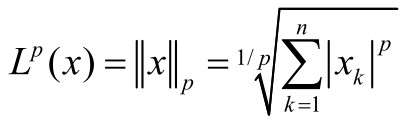

- L1正则化也称为lasso正则化，会使用L1范数将向量条目绝对值的和加以限制，使系数可以完全消失。如果系数降为0，那么这个特征在预测时就没有任何意义，而且肯定不会被SelectFromModel选择
- L2正则化也称为岭正则化，施加惩罚L2范数（向量条目的平方和），让系数不会变成0，但是会非常小

正则化也有助于解决多重共线性的问题，也就是说，数据中有多个线性相关的特征。L1惩罚可以强制其他线性相关特征的系数为0，保证选择器不会选择这些线性相关的特征，有助于解决过拟合问题。

##### 线性模型系数

和之前用树的方法一样，可以用L1和L2正则化为特征选择**寻找最佳系数**。

下面用逻辑回归模型作为选择器，在L1和L2范数上进行网格搜索：

In [103]:
# 用正则化后的逻辑回归进行选择
logistic_selector = SelectFromModel(LogisticRegression())
# 新流水线，用LogistisRegression的参数进行排列
regularization_pipe = Pipeline([
    ('select', logistic_selector),
    ('classifier', d_tree)
])
regularization_pipe_params = deepcopy(tree_pipe_params)
# L1 和L2 正则化
regularization_pipe_params.update({
    'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
    'select__estimator__penalty': ['l1', 'l2'],
})

get_best_model_and_accuracy(
    regularization_pipe,
    regularization_pipe_params,
    X, y
)

最高准确率: 0.8199
最佳参数: {'classifier__max_depth': 3, 'select__estimator__penalty': 'l2', 'select__threshold': 'median'}
拟合的平均时间(s):0.123
预测的平均时间(s):0.001


准确率比统计测试略低。再次使用SelectFromModel的get_support()方法，列出选择的特征：

In [105]:
regularization_pipe.steps[0][1].fit(X, y)
X.columns[regularization_pipe.steps[0][1].get_support()]

Index(['AGE', 'PAY_1'], dtype='object')

可见，逻辑回归选择器只选择了两个特征就达到了81.99%的准确率。接下来用SelectFromModel模块在**支持向量机（SVM）** 分类器上进行测试。

支持向量机是分类模型，在空间中绘制线性边界，对数据进行分类，这些线性边界称为作**支持向量**。逻辑回归分类器和支持向量分类器（SVC）的最大区别在于，后者会最大优化二分类项目的准确性，而前者对属性的建模更好。

下面，用scikit-learn实现一个线性SVC模型:

In [ ]:
# SVC是线性模型，用线性支持在欧几里得空间内分割数据
# 只能解决二分类问题
from sklearn.svm import LinearSVC
# 用SVC取参数
svc_selector = SelectFromModel(LinearSVC())

svc_pipe = Pipeline([
    ('select', svc_selector),
    ('classifier', d_tree)
])
svc_pipe_params = deepcopy(tree_pipe_params)
svc_pipe_params.update({
    'select__threshold': [.01, .05, .1, "mean", "median", "2.*mean"],
    'select__estimator__penalty': ['l1', 'l2'],
    'select__estimator__loss': ['squared_hinge', 'hinge'],
    'select__estimator__dual': [True, False]
})

get_best_model_and_accuracy(
    svc_pipe,
    svc_pipe_params,
    X, y
)

SVC达到了最高的准确率。可以看见拟合时间受到了影响，但是如果能把最快的预测和最好的准确率结合，那么机器学习流水线就会很出色了：基于SVC，利用正则化为决策树分类器找到最佳特征。

下面看看选择器选择了哪些特征来达到目前的最佳准确率：

In [ ]:
svc_pipe.steps[0][1].fit(X, y)
X.columns[svc_pipe.steps[0][1].get_support()]

## 5.4 选用正确的特征选择方法

我们已经知道，选择特征的方法主要有两类：

- 基于统计学
- 基于机器学习模型的二次输出

那么，二者之间该选谁呢？最理想的情况是向本章这样多次尝试，但这样是不可行的。下面是一些经验作为指导下建议，可以帮助你做出恰当选择：

 - 如果特征是分类的，那么从SelectKBest开始，用卡方或基于树的选择器。
 - 如果特征基本是定量的，用线性模型和基于相关性的选择器一般效果更好
 - 如果是二元分类问题，考虑使用SelectFromModel和SVC，因为SVC会查找优化二元分类任务的系数
 - 在手动选择前，探索性数据分析会很有益处。不能低估领域知识的重要性
 
本章的方式仅适合数据集特征较少的情况，如果数据集（如图像和文本）有很多特征（超过100），就要考虑数学转换的方法，以减少处理大量特征的工作量和特征难以解释的问题。